<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [2]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

# **GitHub**

In [3]:
!git clone https://github.com/Jack3690/INSIST

fatal: destination path 'INSIST' already exists and is not an empty directory.


In [4]:
cd INSIST/data

/content/INSIST/data


In [5]:
!cp -a plot.py /usr/local/lib/python3.7/dist-packages/sedfitter

#**Imports**

In [6]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [7]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **Query**

In [50]:
df = pd.read_csv('M67_PS1.csv')
df =  df.rename(columns = {'raStack':'ra','decStack':'dec'})

In [80]:
df_star = df[df['ps_score']>0.5].copy()[:100]

# **M 31**

In [9]:
df_M31 = Table.read('M31_crossmatch.fits').to_pandas()

In [10]:
df_star = df_M31[:100].copy()
df_star =  df_star.rename(columns = {'RAJ2000':'ra','DEJ2000':'dec'})

In [11]:
df_star

,Filter,ra,dec,ABmag,mag,Errmag,Field,M31Cat,objid,raStack,decStack,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,b'FUVCaF2 ',11.0050,41.372601,22.556999,20.156000,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.303400,0.096491,0.369685,0.043593
1,b'FUVCaF2 ',10.8824,41.446201,22.525999,20.125000,0.102,"b'1, 2 '",3,157730108824256022,10.882441,41.446148,21.872499,0.063081,22.364799,0.120779,21.684299,0.077272,21.827299,0.198476,22.543200,0.806140,0.012833,0.222159
2,b'FUVCaF2 ',11.0068,41.368599,22.677999,20.277000,0.113,"b'1, 2 '",3,157640110067852870,11.006835,41.368553,20.694000,0.022622,20.539499,0.021383,20.524500,0.028266,20.584499,0.054087,20.421499,0.097740,0.040125,0.192727
3,b'FUVCaF2 ',10.9376,41.415699,22.198000,19.797001,0.093,"b'1, 2 '",3,157690109375969504,10.937593,41.415661,20.555000,0.022185,20.558201,0.025005,20.419001,0.022528,20.097500,0.036679,20.198799,0.090087,0.012375,0.137362
4,b'FUVCaF2 ',10.9585,41.384899,23.364000,20.962999,0.161,"b'1, 2 '",3,157660109585222564,10.958540,41.385006,21.745300,0.072161,21.099100,0.037309,20.879101,0.032354,20.508499,0.050840,20.969400,0.200653,0.075208,0.400405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,b'FUVCaF2 ',10.9088,41.405201,19.025999,16.625000,0.030,"b'1, 2 '",3,157680109088176802,10.908823,41.405154,18.884800,0.005528,19.245399,0.008082,19.507900,0.012065,19.556999,0.025200,19.277700,0.047474,0.759917,0.180560
96,b'FUVCaF2 ',10.9396,41.384399,22.238001,19.837000,0.093,"b'1, 2 '",3,157660109395181930,10.939563,41.384430,21.180099,0.034122,21.089701,0.036928,21.872900,0.087673,21.657600,0.157647,19.902901,0.075637,0.301827,0.148406
97,b'FUVCaF2 ',10.9231,41.390701,22.039000,19.638000,0.091,"b'1, 2 '",3,157660109230279348,10.923052,41.390676,21.830799,0.066405,21.673700,0.075814,21.445400,0.077254,20.751101,0.098317,21.226500,0.251689,0.474494,0.158721
98,b'FUVCaF2 ',10.8954,41.400700,21.062000,18.660999,0.059,"b'1, 2 '",3,157680108953611505,10.895423,41.400777,20.543699,0.023517,21.021400,0.038443,21.500799,0.071438,21.929300,0.220957,22.582100,0.805896,0.042250,0.286211


# **Synthetic Spectra**

## **Model**

In [12]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [13]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  6969k      0  0:00:12  0:00:12 --:--:-- 11.1M


In [14]:
!tar -xzf models

In [15]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [16]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

model_dir = 'models_kurucz'

filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0]*u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [17]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


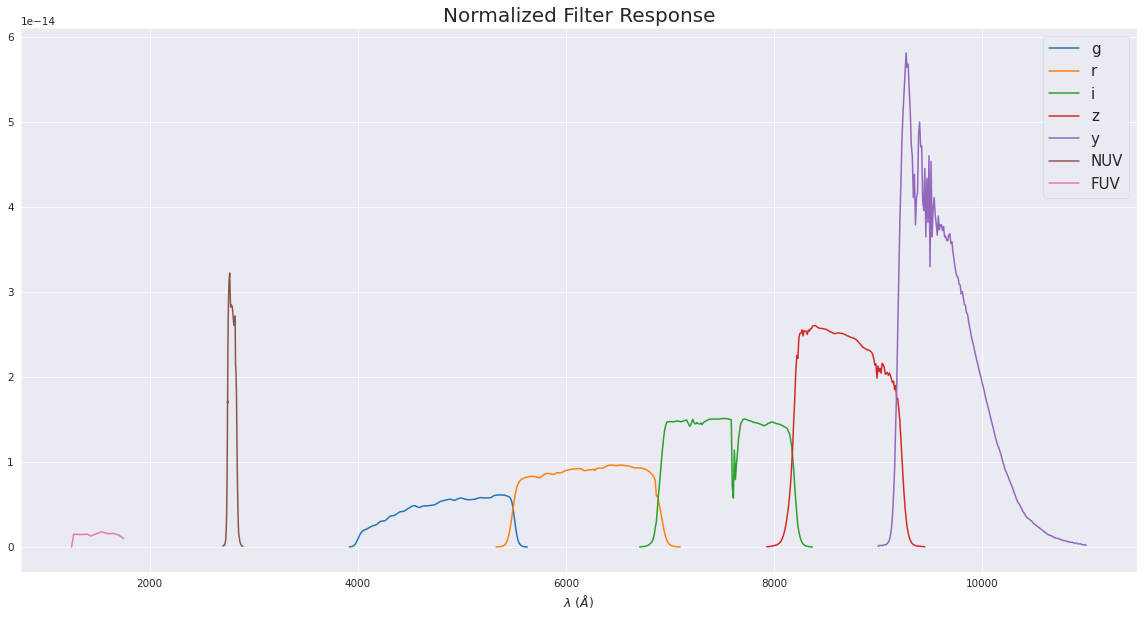

In [18]:
plt.figure(figsize = (20,10))
for filter in filter_list:
  plt.plot(3e18/np.flip(filter.nu),filter.response)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])

## **SED Fitting**

### **SED Fitter**

#### **Data**

In [91]:
df_star 

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,raStack,decStack,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,b'FUVCaF2 ',11.0050,41.372601,22.556999,20.156000,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.303400,0.096491,0.369685,0.043593
1,b'FUVCaF2 ',10.8824,41.446201,22.525999,20.125000,0.102,"b'1, 2 '",3,157730108824256022,10.882441,41.446148,21.872499,0.063081,22.364799,0.120779,21.684299,0.077272,21.827299,0.198476,22.543200,0.806140,0.012833,0.222159
2,b'FUVCaF2 ',11.0068,41.368599,22.677999,20.277000,0.113,"b'1, 2 '",3,157640110067852870,11.006835,41.368553,20.694000,0.022622,20.539499,0.021383,20.524500,0.028266,20.584499,0.054087,20.421499,0.097740,0.040125,0.192727
3,b'FUVCaF2 ',10.9376,41.415699,22.198000,19.797001,0.093,"b'1, 2 '",3,157690109375969504,10.937593,41.415661,20.555000,0.022185,20.558201,0.025005,20.419001,0.022528,20.097500,0.036679,20.198799,0.090087,0.012375,0.137362
4,b'FUVCaF2 ',10.9585,41.384899,23.364000,20.962999,0.161,"b'1, 2 '",3,157660109585222564,10.958540,41.385006,21.745300,0.072161,21.099100,0.037309,20.879101,0.032354,20.508499,0.050840,20.969400,0.200653,0.075208,0.400405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,b'FUVCaF2 ',10.9088,41.405201,19.025999,16.625000,0.030,"b'1, 2 '",3,157680109088176802,10.908823,41.405154,18.884800,0.005528,19.245399,0.008082,19.507900,0.012065,19.556999,0.025200,19.277700,0.047474,0.759917,0.180560
96,b'FUVCaF2 ',10.9396,41.384399,22.238001,19.837000,0.093,"b'1, 2 '",3,157660109395181930,10.939563,41.384430,21.180099,0.034122,21.089701,0.036928,21.872900,0.087673,21.657600,0.157647,19.902901,0.075637,0.301827,0.148406
97,b'FUVCaF2 ',10.9231,41.390701,22.039000,19.638000,0.091,"b'1, 2 '",3,157660109230279348,10.923052,41.390676,21.830799,0.066405,21.673700,0.075814,21.445400,0.077254,20.751101,0.098317,21.226500,0.251689,0.474494,0.158721
98,b'FUVCaF2 ',10.8954,41.400700,21.062000,18.660999,0.059,"b'1, 2 '",3,157680108953611505,10.895423,41.400777,20.543699,0.023517,21.021400,0.038443,21.500799,0.071438,21.929300,0.220957,22.582100,0.805896,0.042250,0.286211


In [106]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

In [107]:
df_star['g_flag']  = 1
df_star['i_flag']  = 1
df_star['r_flag']  = 1
df_star['z_flag']  = 1
df_star['y_flag']  = 1

In [108]:
df_star = df_star.drop_duplicates('objid')
df_star

,Filter,ra,dec,ABmag,mag,Errmag,Field,M31Cat,objid,raStack,decStack,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag
0,b'FUVCaF2 ',11.0050,41.372601,22.556999,20.156000,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.303400,0.096491,0.369685,0.043593,0.028797,0.000439,0.025456,0.000518,0.023214,0.000516,0.026198,0.001502,0.027458,0.002431,1,1,1,1,1
1,b'FUVCaF2 ',10.8824,41.446201,22.525999,20.125000,0.102,"b'1, 2 '",3,157730108824256022,10.882441,41.446148,21.872499,0.063081,22.364799,0.120779,21.684299,0.077272,21.827299,0.198476,22.543200,0.806140,0.012833,0.222159,0.006472,0.000375,0.004113,0.000456,0.007697,0.000546,0.006747,0.001229,0.003489,0.002581,1,1,1,1,1
2,b'FUVCaF2 ',11.0068,41.368599,22.677999,20.277000,0.113,"b'1, 2 '",3,157640110067852870,11.006835,41.368553,20.694000,0.022622,20.539499,0.021383,20.524500,0.028266,20.584499,0.054087,20.421499,0.097740,0.040125,0.192727,0.019161,0.000398,0.022092,0.000433,0.022399,0.000581,0.021195,0.001052,0.024628,0.002208,1,1,1,1,1
3,b'FUVCaF2 ',10.9376,41.415699,22.198000,19.797001,0.093,"b'1, 2 '",3,157690109375969504,10.937593,41.415661,20.555000,0.022185,20.558201,0.025005,20.419001,0.022528,20.097500,0.036679,20.198799,0.090087,0.012375,0.137362,0.021778,0.000443,0.021714,0.000498,0.024685,0.000510,0.033191,0.001117,0.030235,0.002499,1,1,1,1,1
4,b'FUVCaF2 ',10.9585,41.384899,23.364000,20.962999,0.161,"b'1, 2 '",3,157660109585222564,10.958540,41.385006,21.745300,0.072161,21.099100,0.037309,20.879101,0.032354,20.508499,0.050840,20.969400,0.200653,0.075208,0.400405,0.007276,0.000482,0.013194,0.000452,0.016158,0.000480,0.022731,0.001060,0.014868,0.002737,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,b'FUVCaF2 ',10.9088,41.405201,19.025999,16.625000,0.030,"b'1, 2 '",3,157680109088176802,10.908823,41.405154,18.884800,0.005528,19.245399,0.008082,19.507900,0.012065,19.556999,0.025200,19.277700,0.047474,0.759917,0.180560,0.101416,0.000514,0.072756,0.000539,0.057130,0.000632,0.054604,0.001262,0.070623,0.003076,1,1,1,1,1
96,b'FUVCaF2 ',10.9396,41.384399,22.238001,19.837000,0.093,"b'1, 2 '",3,157660109395181930,10.939563,41.384430,21.180099,0.034122,21.089701,0.036928,21.872900,0.087673,21.657600,0.157647,19.902901,0.075637,0.301827,0.148406,0.012246,0.000383,0.013309,0.000451,0.006469,0.000520,0.007888,0.001141,0.039707,0.002755,1,1,1,1,1
97,b'FUVCaF2 ',10.9231,41.390701,22.039000,19.638000,0.091,"b'1, 2 '",3,157660109230279348,10.923052,41.390676,21.830799,0.066405,21.673700,0.075814,21.445400,0.077254,20.751101,0.098317,21.226500,0.251689,0.474494,0.158721,0.006725,0.000410,0.007772,0.000541,0.009591,0.000680,0.018180,0.001640,0.011733,0.002709,1,1,1,1,1
98,b'FUVCaF2 ',10.8954,41.400700,21.062000,18.660999,0.059,"b'1, 2 '",3,157680108953611505,10.895423,41.400777,20.543699,0.023517,21.021400,0.038443,21.500799,0.071438,21.929300,0.220957,22.582100,0.805896,0.042250,0.286211,0.022006,0.000475,0.014173,0.000500,0.009114,0.000597,0.006142,0.001245,0.003367,0.002489,1,1,1,1,1


In [109]:
df_star['gPSFFlux']*(4.7e-9)/(3631e3)    # ergs cm-2 s-1 A-1

0     3.727504e-17
1     8.377184e-18
2     2.480263e-17
3     2.819017e-17
4     9.418413e-18
          ...     
95    1.312737e-16
96    1.585105e-17
97    8.705189e-18
98    2.848513e-17
99    4.202021e-16
Name: gPSFFlux, Length: 100, dtype: float64

In [110]:
df_star['rPSFFlux']*(2.87e-9 )/(3631e3) 

0     2.012066e-17
1     3.250589e-18
2     1.746153e-17
3     1.716333e-17
4     1.042898e-17
          ...     
95    5.750718e-17
96    1.051966e-17
97    6.143301e-18
98    1.120267e-17
99    2.268620e-16
Name: rPSFFlux, Length: 100, dtype: float64

In [111]:
df_star['iPSFFlux']*(1.93e-9 )/(3631e3) 

0     1.233892e-17
1     4.091076e-18
2     1.190577e-17
3     1.312070e-17
4     8.588493e-18
          ...     
95    3.036667e-17
96    3.438724e-18
97    5.097969e-18
98    4.844374e-18
99    1.740513e-16
Name: iPSFFlux, Length: 100, dtype: float64

In [112]:
df_star['zPSFFlux']*(1.45e-9 )/(3631e3) 

0     1.046183e-17
1     2.694315e-18
2     8.463856e-18
3     1.325464e-17
4     9.077544e-18
          ...     
95    2.180561e-17
96    3.150125e-18
97    7.259852e-18
98    2.452719e-18
99    1.221260e-16
Name: zPSFFlux, Length: 100, dtype: float64

In [113]:
df_star['yPSFFlux']*(1.18e-9)/(3631e3) 

0     8.923228e-18
1     1.133972e-18
2     8.003543e-18
3     9.825674e-18
4     4.831943e-18
          ...     
95    2.295101e-17
96    1.290392e-17
97    3.813135e-18
98    1.094062e-18
99    1.023392e-16
Name: yPSFFlux, Length: 100, dtype: float64

In [114]:
filters = ['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ]

In [115]:
df_star[filters]

,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
0,20.251699,20.385599,20.485701,20.354401,20.303400
1,21.872499,22.364799,21.684299,21.827299,22.543200
2,20.694000,20.539499,20.524500,20.584499,20.421499
3,20.555000,20.558201,20.419001,20.097500,20.198799
4,21.745300,21.099100,20.879101,20.508499,20.969400
...,...,...,...,...,...
95,18.884800,19.245399,19.507900,19.556999,19.277700
96,21.180099,21.089701,21.872900,21.657600,19.902901
97,21.830799,21.673700,21.445400,20.751101,21.226500
98,20.543699,21.021400,21.500799,21.929300,22.582100


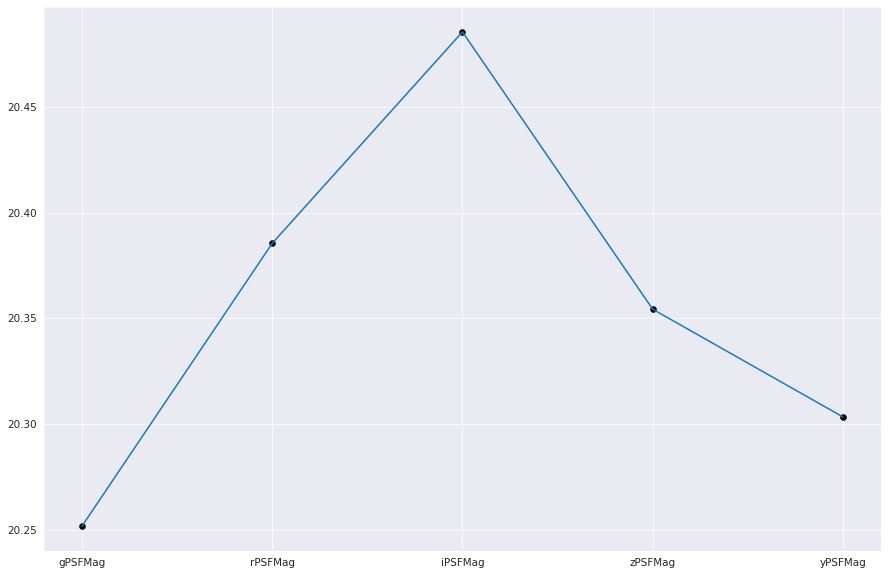

In [116]:
for i,flux in df_star[filters].iterrows():
  plt.scatter(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux,marker = 'o', color = 'black')
  plt.plot(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux)
  break

In [117]:
df_out = df_star[['objid', 'ra', 'dec','g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

In [118]:
df_out 

,objid,ra,dec,g_flag,i_flag,r_flag,z_flag,y_flag,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
0,157640110050187706,11.0050,41.372601,1,1,1,1,1,0.028797,0.000439,0.025456,0.000518,0.023214,0.000516,0.026198,0.001502,0.027458,0.002431
1,157730108824256022,10.8824,41.446201,1,1,1,1,1,0.006472,0.000375,0.004113,0.000456,0.007697,0.000546,0.006747,0.001229,0.003489,0.002581
2,157640110067852870,11.0068,41.368599,1,1,1,1,1,0.019161,0.000398,0.022092,0.000433,0.022399,0.000581,0.021195,0.001052,0.024628,0.002208
3,157690109375969504,10.9376,41.415699,1,1,1,1,1,0.021778,0.000443,0.021714,0.000498,0.024685,0.000510,0.033191,0.001117,0.030235,0.002499
4,157660109585222564,10.9585,41.384899,1,1,1,1,1,0.007276,0.000482,0.013194,0.000452,0.016158,0.000480,0.022731,0.001060,0.014868,0.002737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,157680109088176802,10.9088,41.405201,1,1,1,1,1,0.101416,0.000514,0.072756,0.000539,0.057130,0.000632,0.054604,0.001262,0.070623,0.003076
96,157660109395181930,10.9396,41.384399,1,1,1,1,1,0.012246,0.000383,0.013309,0.000451,0.006469,0.000520,0.007888,0.001141,0.039707,0.002755
97,157660109230279348,10.9231,41.390701,1,1,1,1,1,0.006725,0.000410,0.007772,0.000541,0.009591,0.000680,0.018180,0.001640,0.011733,0.002709
98,157680108953611505,10.8954,41.400700,1,1,1,1,1,0.022006,0.000475,0.014173,0.000500,0.009114,0.000597,0.006142,0.001245,0.003367,0.002489


In [119]:
df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

#### **Fit**

In [120]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.000 Mpc

 ------------------------------------------------------------
  => Output parameters
 ----

In [70]:
tab = extinction.to_table()

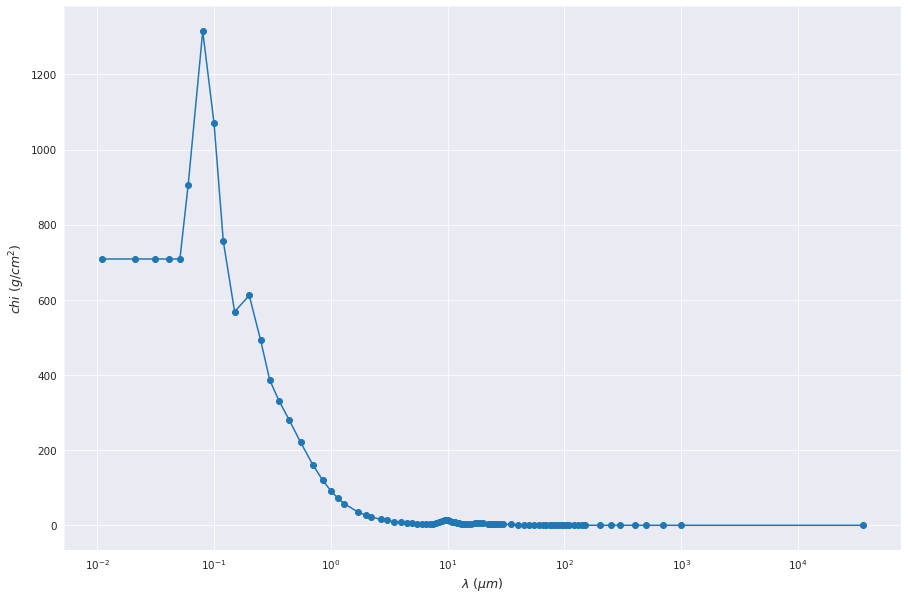

In [71]:
plt.plot(tab['wav'],tab['chi'],'o-')
plt.xscale('log')
plt.xlabel(r"$\lambda$ ($\mu m$)")
plt.ylabel(r"$chi$ ($g/cm^2$)");


Extracting fitting parameters from SED Fitter output

In [ ]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds',format='png' , dpi = 1024)

Delete directory plots_seds? [y/[n]] y



In [133]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 


flux     = []
flux_err = []
chi2     = []
Avs      = []
scs      = []

model_names = []
for info in fin:
  Avs.append(info.av[0])
  scs.append(info.sc[0])
  model_name = info.model_name[0]
  model_names.append(model_name)
  chi2.append(info.chi2[0])

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1],g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

scs = np.array(scs)

In [135]:
tab_star = Table.from_pandas(df_star)

tab_star['model_flux']     = flux
tab_star['Av']             = Avs
tab_star['Sc']             = scs
tab_star['model_mag']      = -2.5*np.log10(tab_star['model_flux']/3631e3)
tab_star['chi2'] =chi2

In [ ]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']
for i,fl in df_star[filters].iterrows():
  plt.plot(x,fl, 'o-', color = 'black')
  break
  
plt.plot(x,tab_star['model_mag'].value[0],'o-')
plt.legend(['Observed','Model'])

In [1]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

NameError: ignored

### **SED Fitting Routine**

EMCEE : Bayesian. 

#### **Data**

In [19]:
df_star

,Filter,ra,dec,ABmag,mag,Errmag,Field,M31Cat,objid,raStack,decStack,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,b'FUVCaF2 ',11.0050,41.372601,22.556999,20.156000,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.303400,0.096491,0.369685,0.043593
1,b'FUVCaF2 ',10.8824,41.446201,22.525999,20.125000,0.102,"b'1, 2 '",3,157730108824256022,10.882441,41.446148,21.872499,0.063081,22.364799,0.120779,21.684299,0.077272,21.827299,0.198476,22.543200,0.806140,0.012833,0.222159
2,b'FUVCaF2 ',11.0068,41.368599,22.677999,20.277000,0.113,"b'1, 2 '",3,157640110067852870,11.006835,41.368553,20.694000,0.022622,20.539499,0.021383,20.524500,0.028266,20.584499,0.054087,20.421499,0.097740,0.040125,0.192727
3,b'FUVCaF2 ',10.9376,41.415699,22.198000,19.797001,0.093,"b'1, 2 '",3,157690109375969504,10.937593,41.415661,20.555000,0.022185,20.558201,0.025005,20.419001,0.022528,20.097500,0.036679,20.198799,0.090087,0.012375,0.137362
4,b'FUVCaF2 ',10.9585,41.384899,23.364000,20.962999,0.161,"b'1, 2 '",3,157660109585222564,10.958540,41.385006,21.745300,0.072161,21.099100,0.037309,20.879101,0.032354,20.508499,0.050840,20.969400,0.200653,0.075208,0.400405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,b'FUVCaF2 ',10.9088,41.405201,19.025999,16.625000,0.030,"b'1, 2 '",3,157680109088176802,10.908823,41.405154,18.884800,0.005528,19.245399,0.008082,19.507900,0.012065,19.556999,0.025200,19.277700,0.047474,0.759917,0.180560
96,b'FUVCaF2 ',10.9396,41.384399,22.238001,19.837000,0.093,"b'1, 2 '",3,157660109395181930,10.939563,41.384430,21.180099,0.034122,21.089701,0.036928,21.872900,0.087673,21.657600,0.157647,19.902901,0.075637,0.301827,0.148406
97,b'FUVCaF2 ',10.9231,41.390701,22.039000,19.638000,0.091,"b'1, 2 '",3,157660109230279348,10.923052,41.390676,21.830799,0.066405,21.673700,0.075814,21.445400,0.077254,20.751101,0.098317,21.226500,0.251689,0.474494,0.158721
98,b'FUVCaF2 ',10.8954,41.400700,21.062000,18.660999,0.059,"b'1, 2 '",3,157680108953611505,10.895423,41.400777,20.543699,0.023517,21.021400,0.038443,21.500799,0.071438,21.929300,0.220957,22.582100,0.805896,0.042250,0.286211


In [20]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

#### **Without Av**

In [21]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [22]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    
    chi2   = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [23]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

#### **With Av**

$\chi^2 =\dfrac{1}{N - n_p}\sum\limits_{i=1}^j\left(\dfrac{Y_{i,o} -M_d \times Y_{i,M}\times10^{-0.4\times ext_i\times A_v}}{\sigma_{i,o}}\right)^2$

In [33]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - Md*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

In [34]:
# Convolved Filters

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
ext = np.array([1.18, 0.881, 0.667, 0.534,0.457])
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)
    
    params = minimize(chi2_func,x0 = (1e-2,0.5),bounds=([0,np.inf],[0,np.inf]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row['objid'],model_name[j],Md,Av,chi2])

In [35]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','Av','chi2'])

#### **Minimize chi**

In [36]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [37]:
df_chi_min 

,objid,model_name,Md,Av,chi2
1383,157640110050187706,kt07500g+1.0z-2.5,0.002313,0.172597,8.365718
7602,157730108824256022,kt49000g+5.0z+0.5,0.000082,2.032503,26.792365
9178,157640110067852870,kt08000g+3.5z+0.5,0.002398,0.788000,2.553384
12807,157690109375969504,kt07500g+1.0z-2.5,0.004092,0.991510,40.971728
16602,157660109585222564,kt07500g+0.5z+0.5,0.004599,2.020697,11.043201
...,...,...,...,...,...
363969,157680109088176802,kt10750g+3.0z+0.2,0.002188,0.000000,107.093313
367018,157660109395181930,kt07750g+1.0z+0.5,0.000716,0.000000,187.890014
370831,157660109230279348,kt07750g+1.0z-2.5,0.002374,1.702423,16.210884
376626,157680108953611505,kt31000g+5.0z+0.5,0.000066,0.000000,3.292204


In [38]:
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)
FUV = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1) 

flux     = []
flux_err = []
ext = np.array([1.18, 0.881, 0.667, 0.534,0.457])
model_names = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']


  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  fuv =[FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , FUV[FUV['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([fuv[0], g[0], r[0], i[0], z[0], y[0]])

  flux_err.append([fuv[1],g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

flux_err = np.array(flux_err)

In [44]:
tab_star = Table.from_pandas(df_star)

tab_star['model_flux']     = flux
tab_star['Md']             = df_chi_min['Md']
tab_star['Av']             = df_chi_min['Av']

model_mag = []
ext = np.array([2.67,1.18, 0.881, 0.667, 0.534,0.457])

for row in tab_star:
  Av = row['Av']
  Md = row['Md']
  model_flux = row['model_flux']

  model_mag.append(-2.5*np.log10(Md*model_flux*pow(10,-0.4*ext*Av)/3631e3))

tab_star['model_mag']      = model_mag
tab_star['chi2'] =chi2

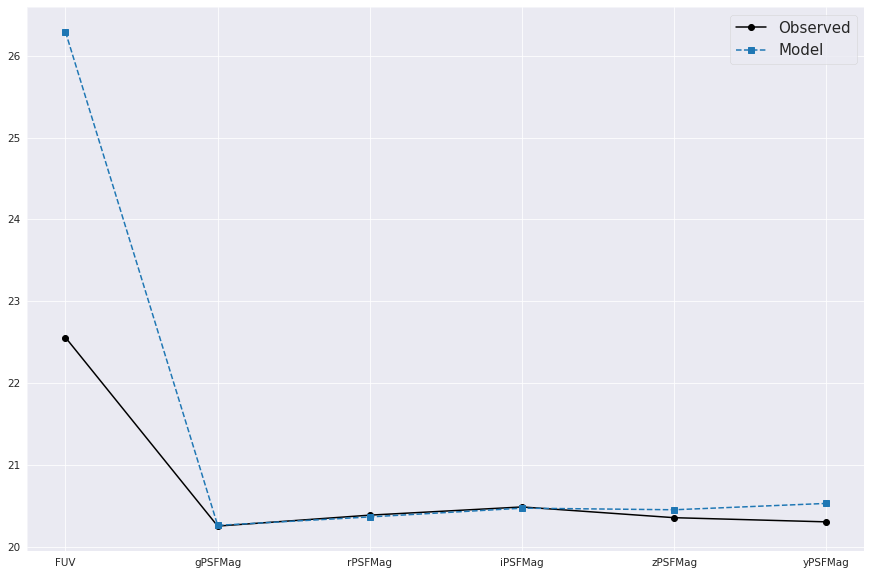

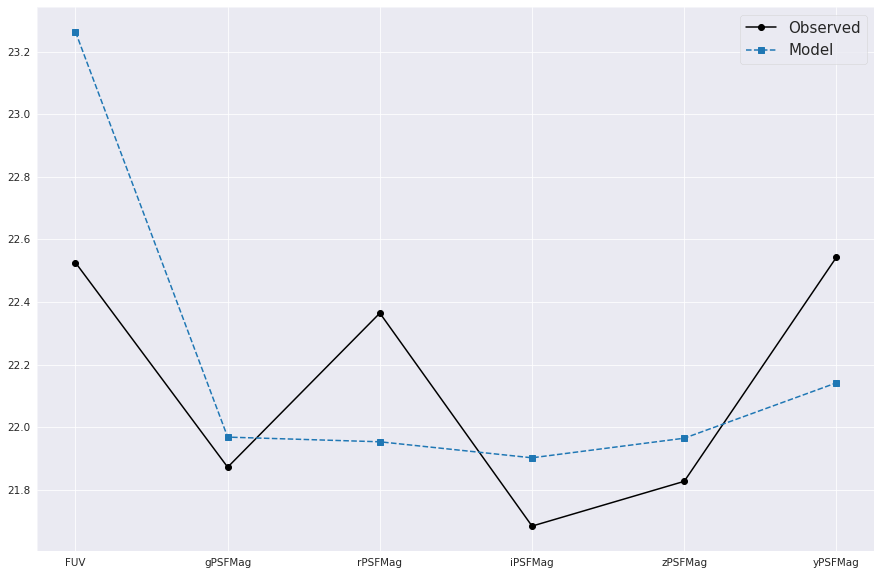

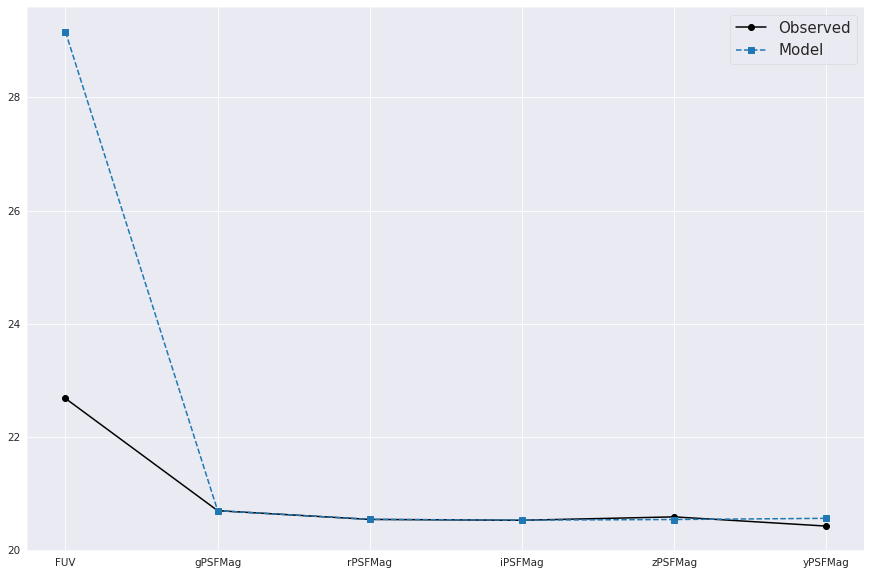

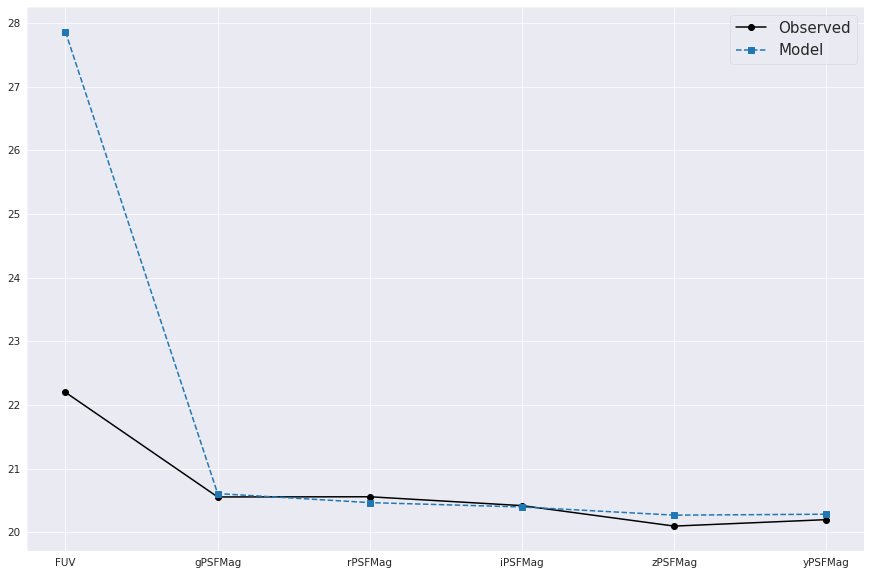

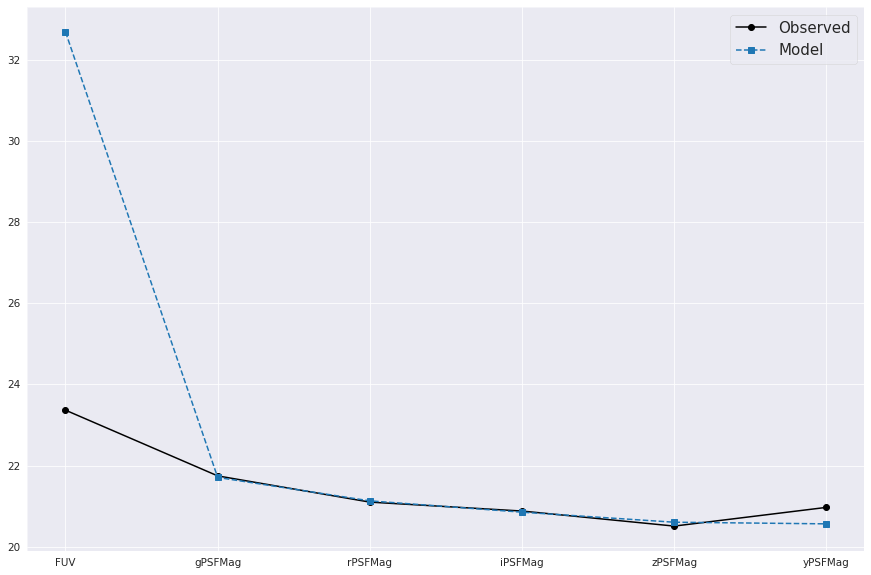

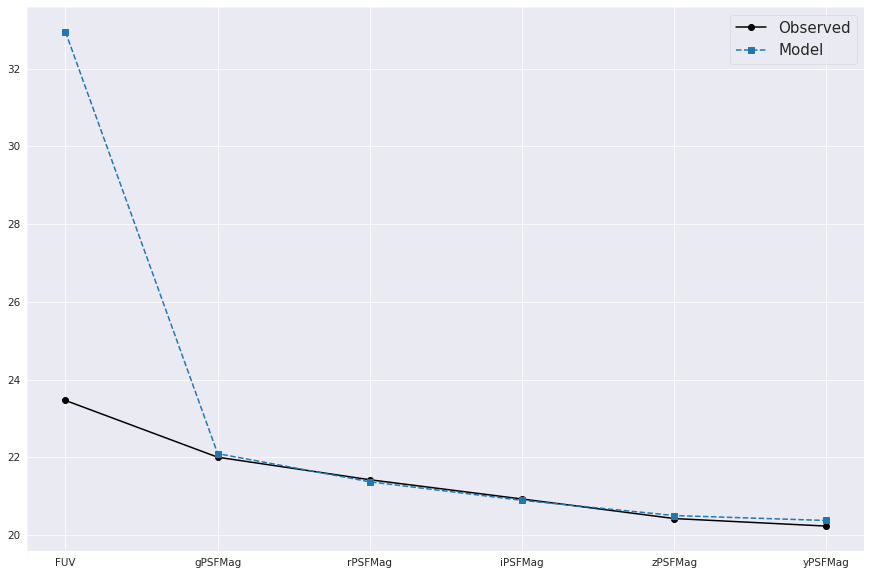

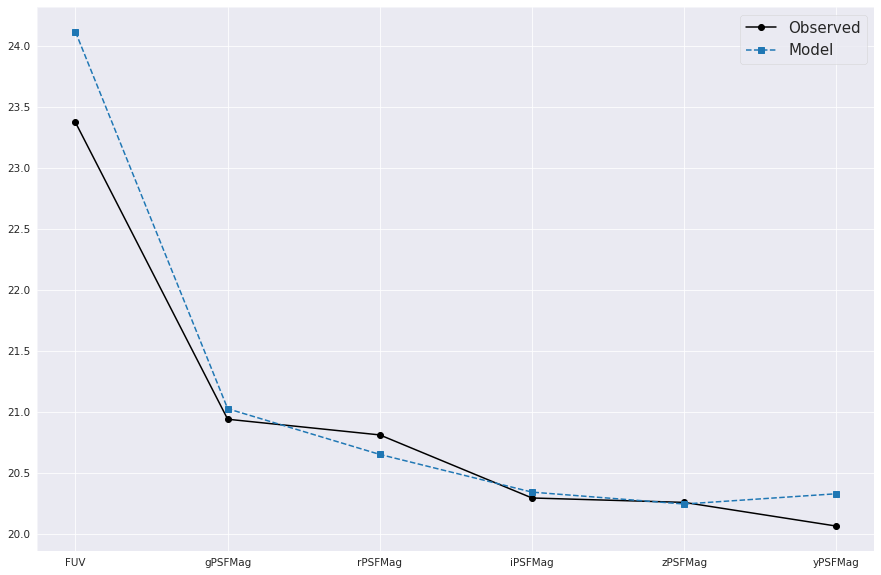

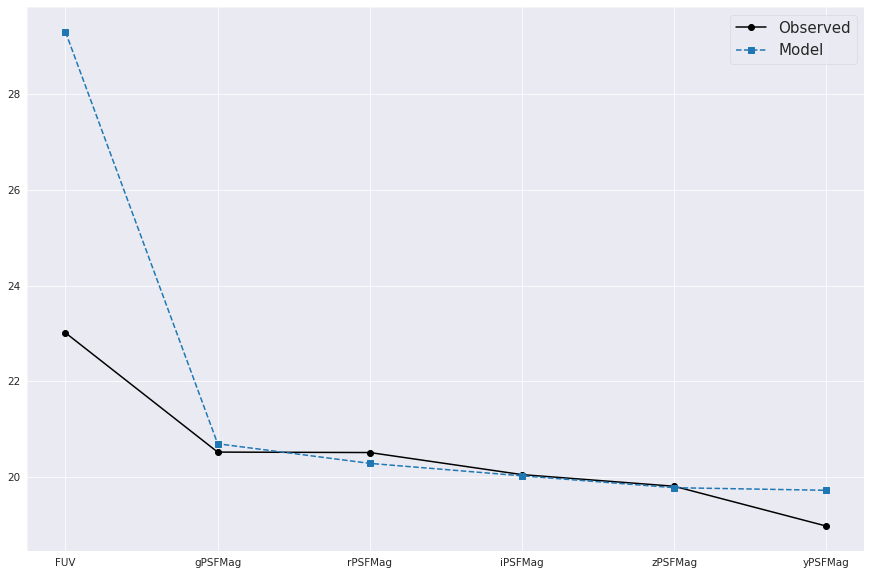

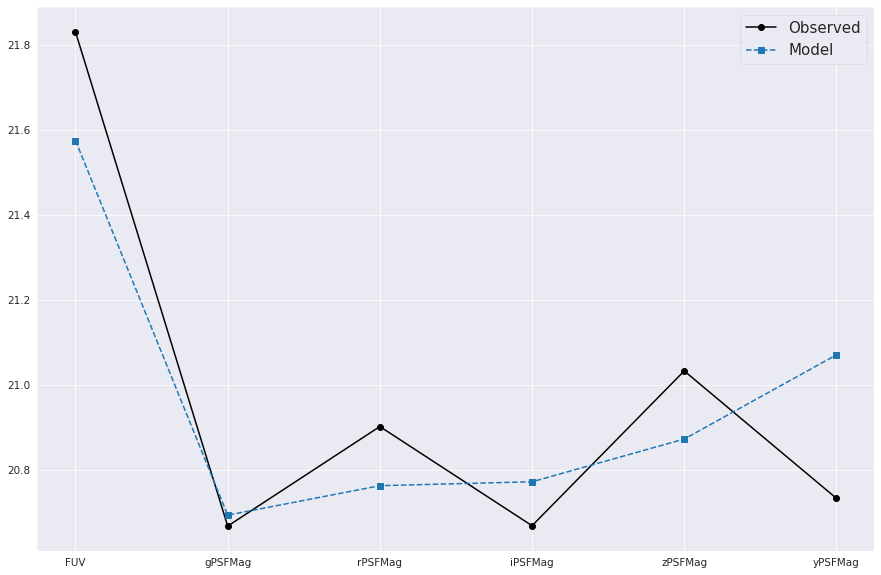

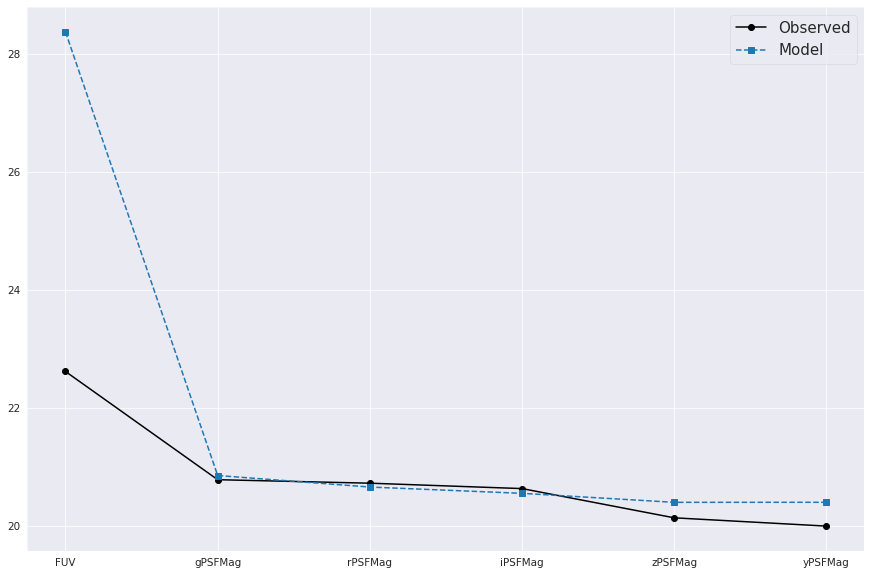

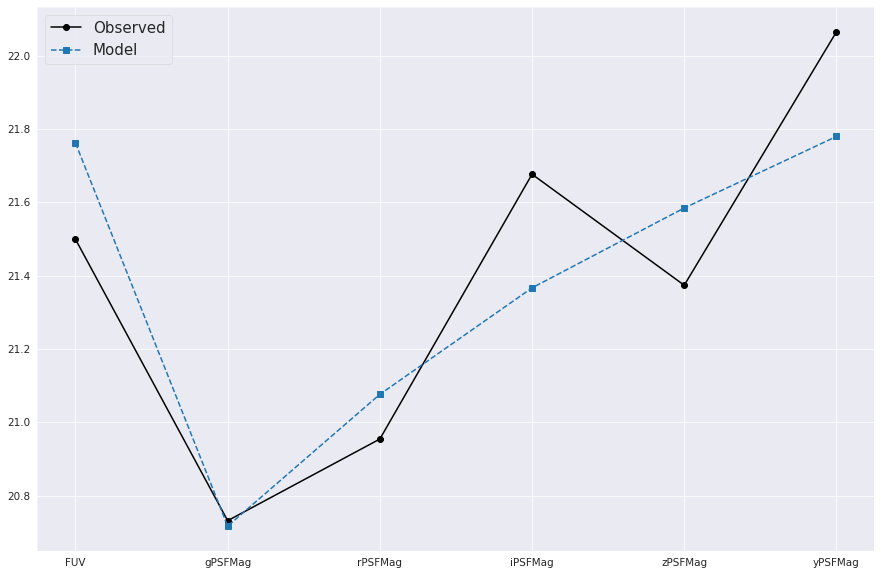

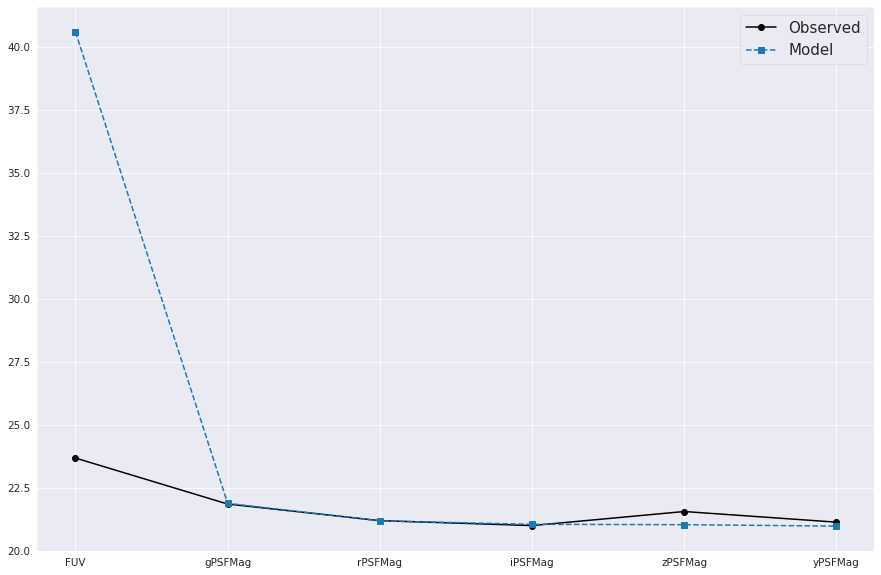

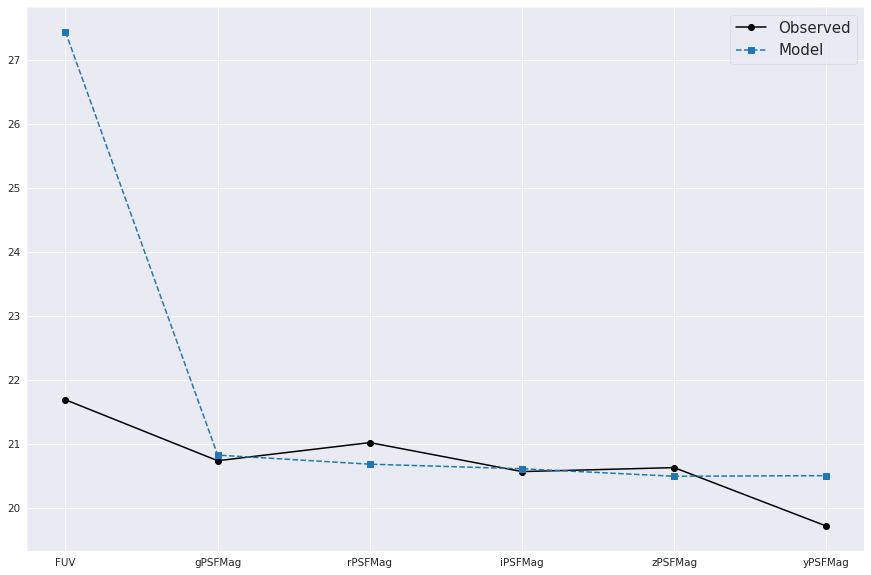

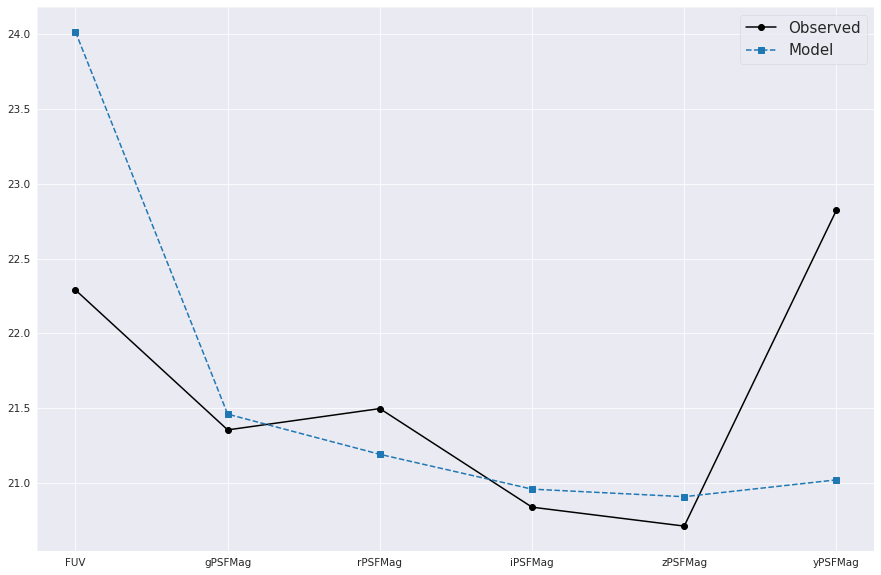

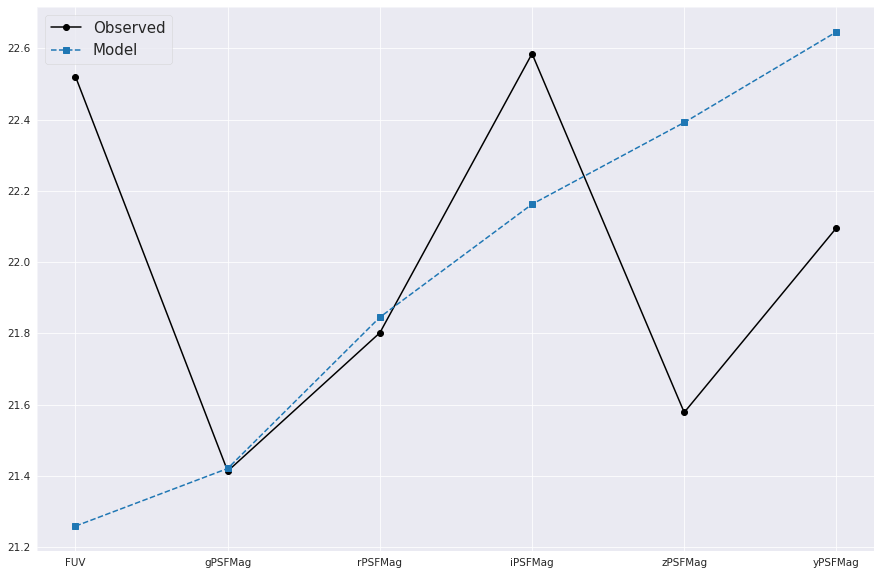

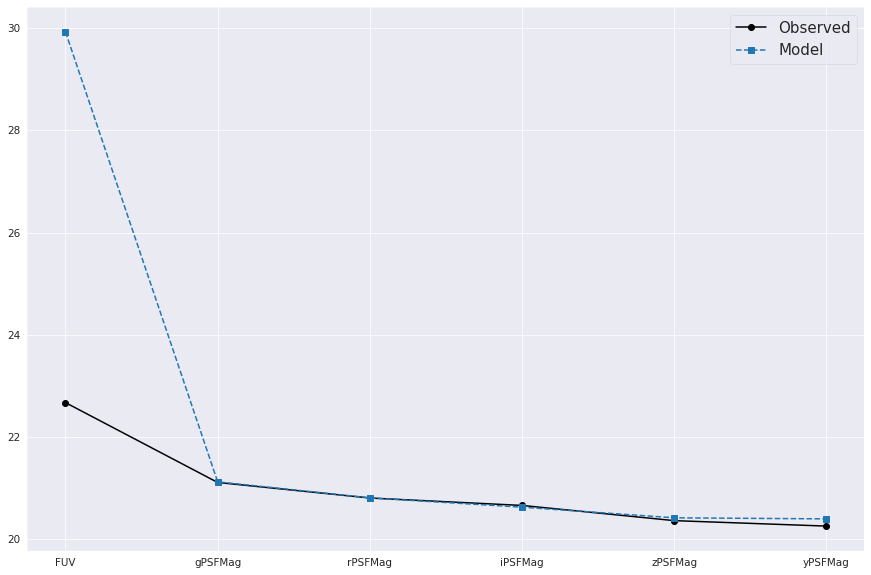

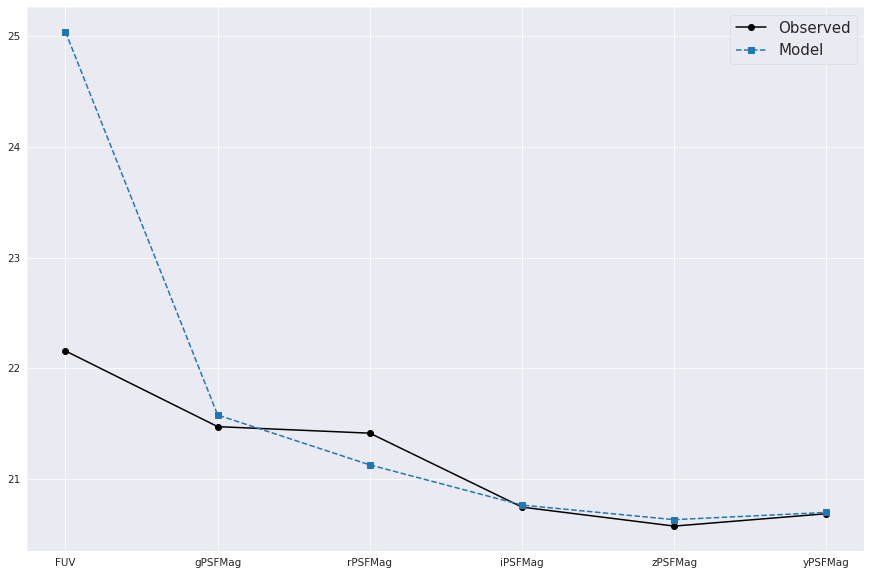

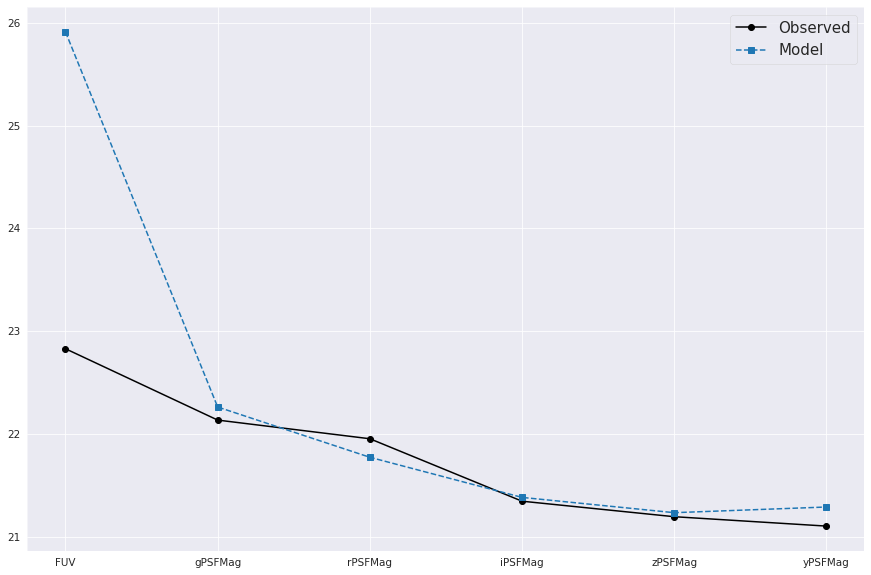

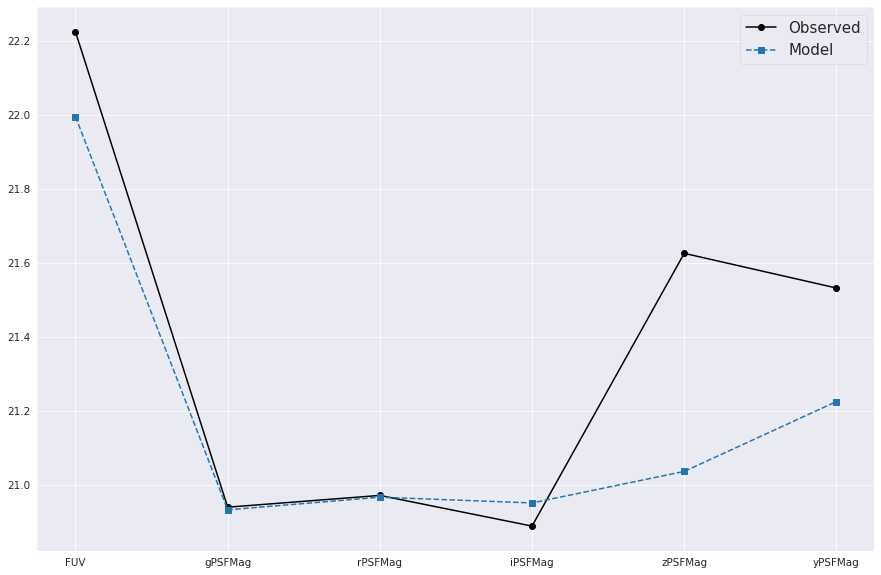

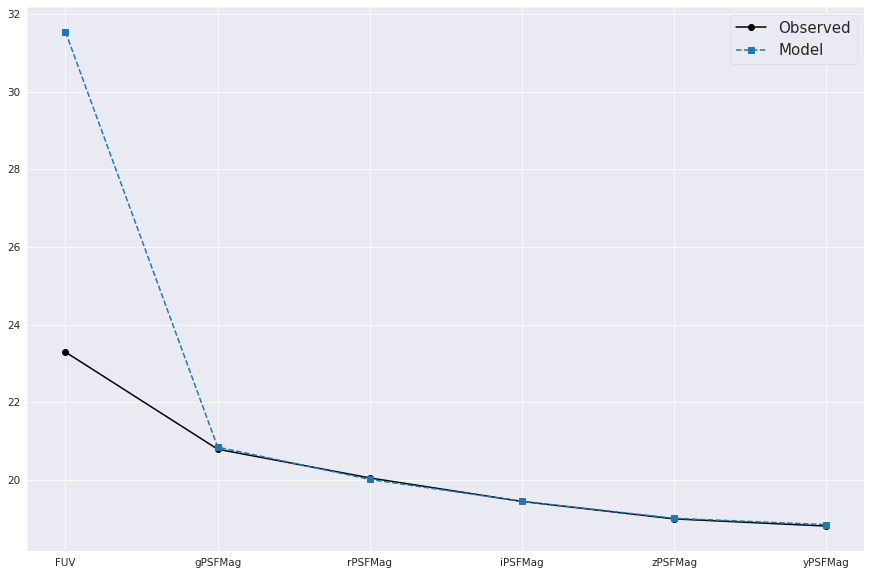

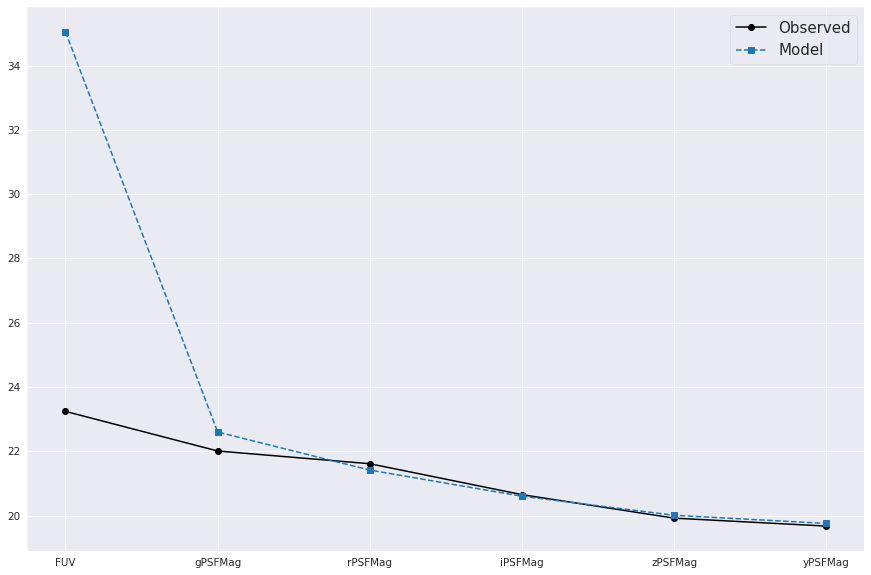

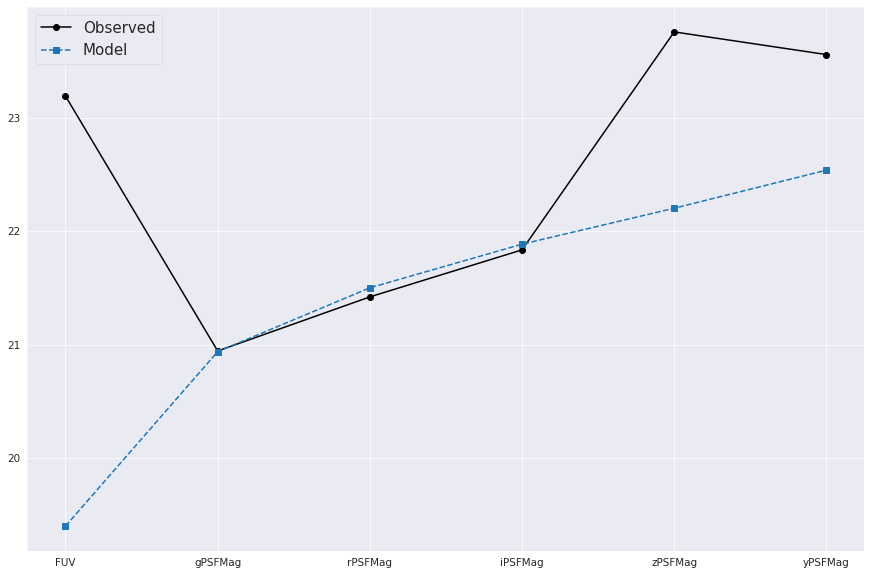

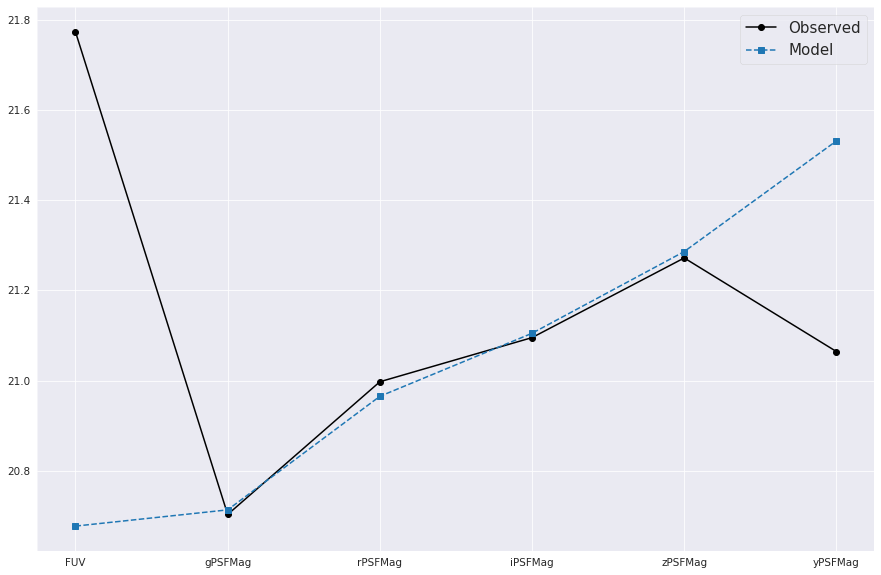

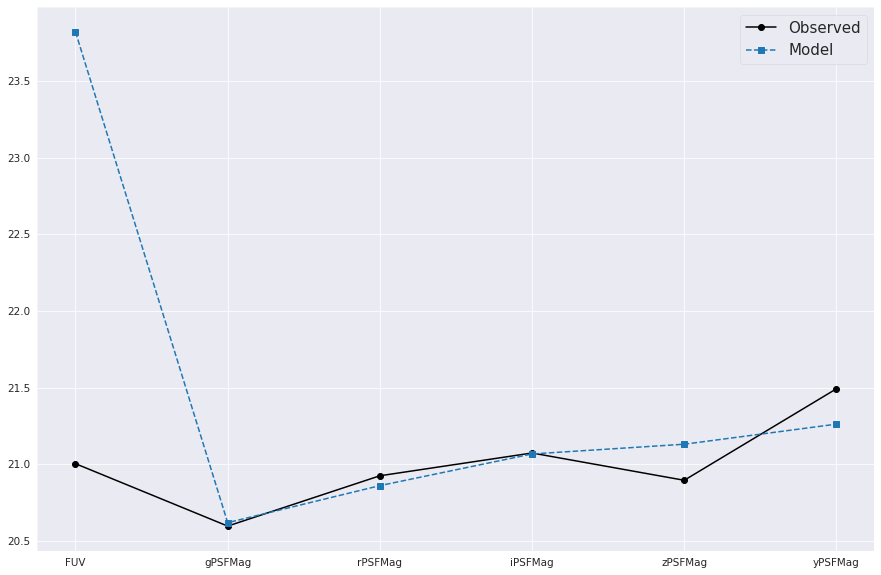

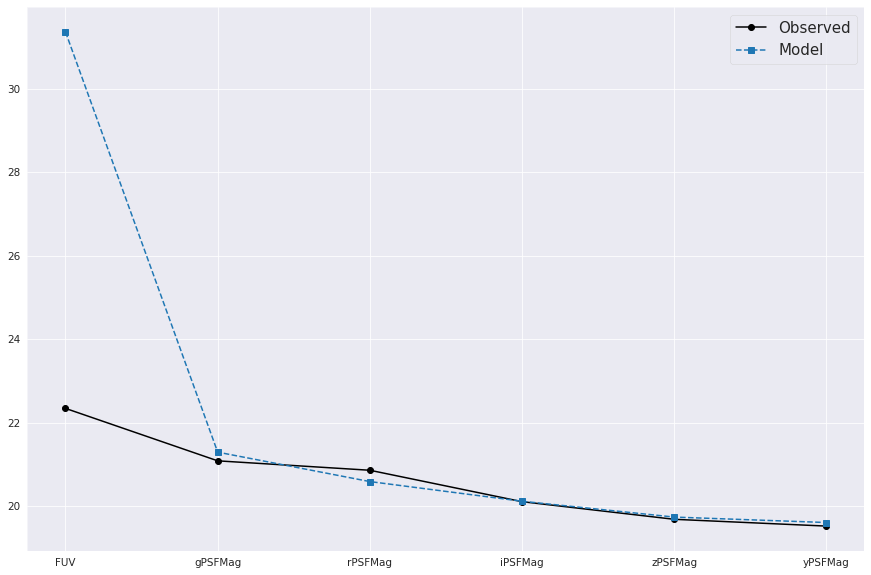

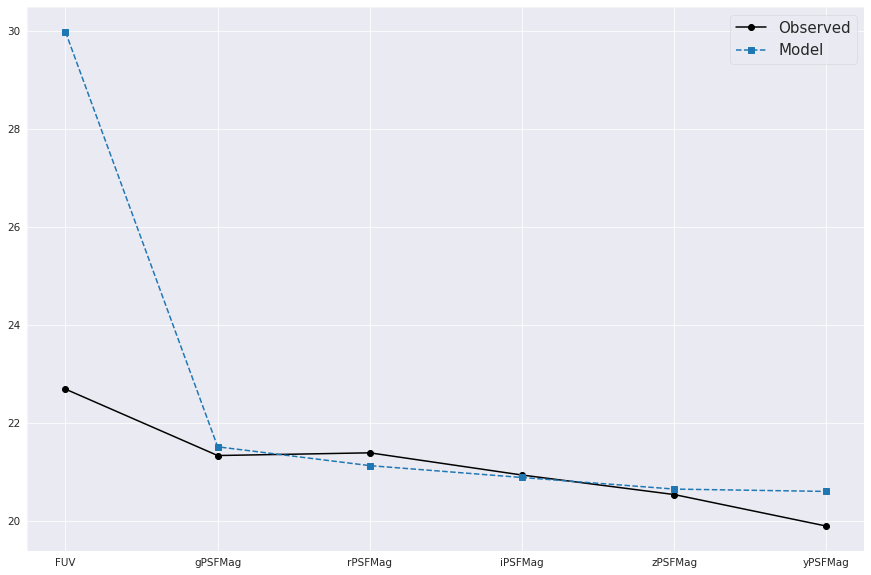

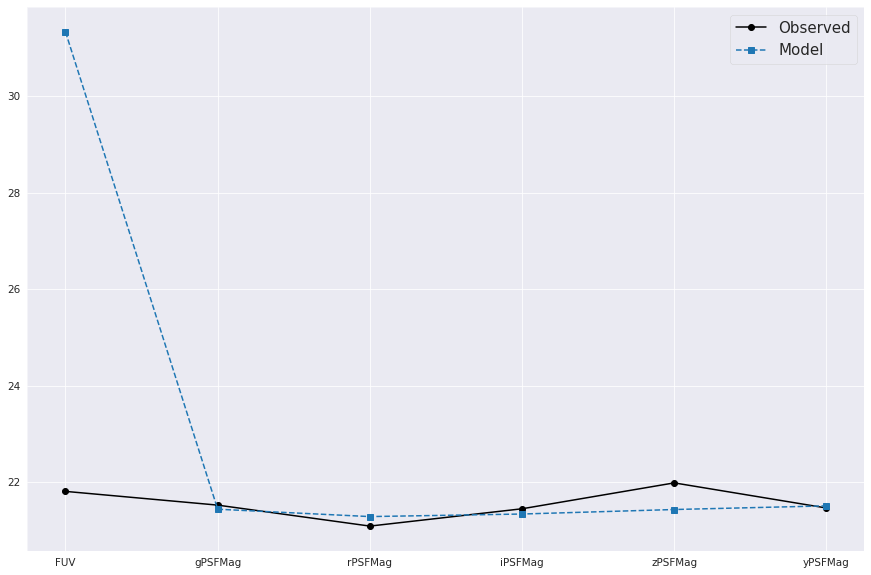

In [ ]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['FUV','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

UV_diff = []
for i,fl in df_star[filters].iterrows():
  plt.plot(x,fl, 'o-', color = 'black')
  UV_diff.append
  plt.plot(x,tab_star['model_mag'].value[i],'s--')

  UV_diff.append(fl[0] - tab_star['model_mag'].value[i][0])
  plt.legend(['Observed','Model'])
  plt.show()